# Regression

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Week 2

In this lab, we will use linear regression to predict the value of a home and explore the impact of regularisation.

### Assumed knowledge
- Maximum likelihood solution to a linear regression problem, with and without regularisation (week 2 lectures)
- Matrix calculations in numpy (week 1 lab and precourse material)
- Theory behind regularisation (week 2 lectures)

### After this lab, you should be comfortable with:
- Practical linear regression problems
- Picking an appropriate regularisation parameter for a given problem

$\newcommand{\trace}[1]{\operatorname{tr}\left\{#1\right\}}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\inner}[2]{\langle #1, #2 \rangle}$
$\newcommand{\DD}{\mathscr{D}}$
$\newcommand{\grad}[1]{\operatorname{grad}#1}$
$\DeclareMathOperator*{\argmin}{arg\,min}$

Setting up the environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## The data set


We will use [a dataset](https://machlearn.gitlab.io/sml2019/tutorials/02-dataset.csv) on the price of housing in Boston (see [description](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)). 
We aim to predict the value of a home from other factors.
In this dataset, each row is one house. The first entry is the value of the house and we will predict it from the remaining values which have been normalised to be in the range $[-1, 1]$. The column labels are

```'medv', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat'```

Download the dataset. Read in the data using ```np.loadtxt``` with the optional argument ```delimiter=','```, as our data is comma separated rather than space separated. Remove the column containing the binary variable ```'chas'```.

In [2]:
# Solution
names = ['medv', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
loaded_data = np.loadtxt('02-dataset.csv', delimiter=',')

# remove chas
column_idxes = list(range(len(names)))
chas_idx = names.index('chas')
wanted_columns = list(column_idxes)
wanted_columns.remove(chas_idx)
data = loaded_data[:,wanted_columns]
data_names = list(names)
data_names.remove('chas')

Check that the data is as expected using ```print()```. It should have 506 rows (examples) and 13 columns (1 label and 12 features). Check that this is the case. 

Hint: use  assert.

In [3]:
# Solution
print(data_names)
print(np.array_str(data[:5], precision=3))
assert data.shape == (506,13), data.shape

['medv', 'crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
[[24.    -1.    -0.64  -0.864 -0.37   0.155  0.283 -0.462 -1.    -0.584
  -0.426  1.    -0.821]
 [21.    -1.    -1.    -0.515 -0.654  0.096  0.565 -0.302 -0.913 -0.79
   0.106  1.    -0.591]
 [34.    -1.    -1.    -0.515 -0.654  0.389  0.199 -0.302 -0.913 -0.79
   0.106  0.979 -0.873]
 [33.    -0.999 -1.    -0.874 -0.7    0.317 -0.116 -0.103 -0.826 -0.866
   0.298  0.989 -0.933]
 [36.    -0.999 -1.    -0.874 -0.7    0.374  0.057 -0.103 -0.826 -0.866
   0.298  1.    -0.801]]


## Regression without regularisation

Implement a **function** to find the maximum likelihood solution $w_{ML}$ assuming Gaussian noise for this linear regression problem. Remember from the lectures that this is equivalent to a linear regresion problem with the cost function set as the sum of squares error.

In [4]:
# Solution
def w_ml_unregularised(Phi,t):
    return np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t

## Training and testing

Use a fifth of the available data for training the model using maximum likelihood. The rest of the data is allocated to the test set. Report the root mean squared error (RMSE) for the training set and the test set.
In this cases, use the identity map as the basis function, $\phi(x)=x$.

Note that the data may be sorted or ordered in some way we cannot predict. How will you account for this?

In [5]:
# Solution
def split_data(data):
    """Randomly split data into two groups. The first group is a fifth of the data."""
    np.random.seed(1)
    N = len(data)
    idx = np.arange(N)
    np.random.shuffle(idx)
    train_idx = idx[:int(N/5)]
    test_idx = idx[int(N/5):]

    # Assume label is in the first column
    X_train = data[train_idx, 1:]
    t_train = data[train_idx, 0]
    X_test = data[test_idx, 1:]
    t_test = data[test_idx, 0]
    
    return X_train, t_train, X_test, t_test

def rmse(X_train, t_train, X_test, t_test, w):
    """Return the RMSE for training and test sets"""
    N_train = len(X_train)
    N_test = len(X_test)

    # Training set error
    t_train_pred = np.dot(X_train, w)
    rmse_train = np.linalg.norm(t_train_pred - t_train) / np.sqrt(N_train)

    # Test set error
    t_test_pred = np.dot(X_test, w)
    rmse_test = np.linalg.norm(t_test_pred - t_test) / np.sqrt(N_test)

    return rmse_train, rmse_test

X_train, t_train, X_test, t_test = split_data(data)
feature_names = data_names[1:]
w_unreg = w_ml_unregularised(X_train, t_train)


train_rmse, test_rmse = rmse(X_train, t_train, X_test, t_test, w_unreg)
print("RMSE with regularisation: Train {:.6f}, Test {:.6f}".format(train_rmse, test_rmse))

RMSE with regularisation: Train 4.459972, Test 5.376872


## Interpreting the model

Find the feature with the biggest magnitude of weight. Using ```matplotlib``` ([docs for ```matplotlib.pyplot.plot```](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)), create a plot of this feature against the label for the datapoints in the training set. In a different colour, plot this feature against the predicted label. Create a similar plot for the test data.

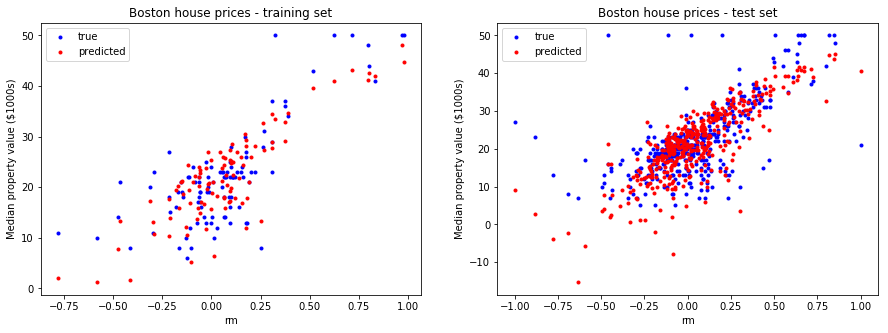

In [6]:
# Solution
max_feature = np.argmax(np.abs(w_unreg))
t_train_pred = np.dot(X_train, w_unreg)
t_test_pred = np.dot(X_test, w_unreg)
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
ax.plot(X_train[:,max_feature], t_train, 'b.', label='true')
ax.plot(X_train[:,max_feature], t_train_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - training set')
ax.set_xlabel(feature_names[max_feature])
ax.set_ylabel('Median property value ($1000s)')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(X_test[:,max_feature], t_test, 'b.', label='true')
ax.plot(X_test[:,max_feature], t_test_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - test set')
ax.set_xlabel(feature_names[max_feature])
ax.set_ylabel('Median property value ($1000s)')
ax.legend()
plt.show()

## Regression with regularisation

Implement a **function** to find the maximum likelihood solution $w_{reg}$ for some regularisation parameter $\lambda > 0$ assuming Gaussian noise for this linear regression problem.

In [7]:
# Solution

def w_ml_regularised(Phi, t, l):
    return np.linalg.inv(l * np.eye(Phi.shape[1]) + Phi.T @ Phi) @ Phi.T @ t

By calculating the RMSE on the training and test sets, evaluate the impact of regularisation for $\lambda = 1.1$.

What is the effect of regularisation?

### Solution

The regularised model performs slightly worse on the training set (higher RMSE), but slightly better on the test set (lower RMSE). Including a regularisation term in the error function means the resulting model is less likely to overfit and therefore performs better on unseen test data. 

In [8]:
# Solution
l=1.1
X_train, t_train, X_test, t_test = split_data(data)
w_reg = w_ml_regularised(X_train, t_train,l)

train_rmse, test_rmse = rmse(X_train, t_train, X_test, t_test, w_reg)
print("RMSE with regularisation: Train {:.6f}, Test {:.6f}".format(train_rmse, test_rmse))

RMSE with regularisation: Train 4.514114, Test 5.302897


## Picking a regularisation parameter

You will now explore picking a good regularisation parameter.

What would you expect to see if you were under-regularising (so the parameter was too small)? Over-regularising? Discuss with a partner.

Plot the RMSE on the training and test sets against the regularisation parameter $\lambda$ for a range of values of $\lambda$. What is a good range of values of $\lambda$ to check? What do you think is the best value?

Hint: You may find you want to plot against $\log(\lambda)$. The functions ``np.arange`` and ``np.linspace`` could be useful here (use whichever you think is more applicable).

### Solution
If it is under-regularising then the error will be similar to the unregularised cases since it will still be overfitting to the train data. If it is over-regularising then the model will be unable to learn more complex features as weights for the basis function becomes limited to the extreme of constant function. Hence, the effect of the basis function becomes low so that the learned model is relatively simpler.

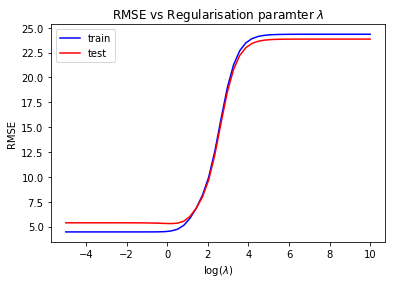

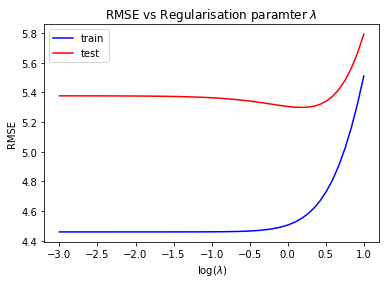

In [9]:
# Solution
log_lambdas = np.linspace(-5, 10)
# Each row is a value of lambda
# Columns are respectively ['rmse_train_linear', 'rmse_test_linear']
results = np.zeros((len(log_lambdas), 2))

for ix, l in enumerate(log_lambdas):
    rmse_train, rmse_test = rmse(X_train, t_train, X_test, t_test, 
                                 w_ml_regularised(X_train, t_train, pow(10,float(l))))
    results[ix, 0] = rmse_train
    results[ix, 1] = rmse_test

#fig = plt.figure(figsize=(15,8))
plt.title('RMSE vs Regularisation paramter $\lambda$')
plt.plot(log_lambdas, results[:,0], 'b-', label='train') # training data
plt.plot(log_lambdas, results[:,1], 'r-', label='test') # test data
plt.xlabel('log($\lambda$)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Look closer at range(-3, 1)

log_lambdas = np.linspace(-3, 1)
# Each row is a value of lambda
# Columns are respectively ['rmse_train_linear', 'rmse_test_linear']
results = np.zeros((len(log_lambdas), 2))

for ix, l in enumerate(log_lambdas):
    rmse_train, rmse_test = rmse(X_train, t_train, X_test, t_test, 
                                 w_ml_regularised(X_train, t_train, pow(10,float(l))))
    results[ix, 0] = rmse_train
    results[ix, 1] = rmse_test

plt.title('RMSE vs Regularisation paramter $\lambda$')
plt.plot(log_lambdas, results[:,0], 'b-', label='train') # training data
plt.plot(log_lambdas, results[:,1], 'r-', label='test') # test data
plt.xlabel('log($\lambda$)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Basis Functions
We want to use basis functions to improve our performance. Implement subroutines for polynomial basis function of degree 2. See [the feature map based on the binomial formula](http://en.wikipedia.org/wiki/Polynomial_kernel) .

In [10]:
# Solution
def phi_quadratic(x):    
    """Compute phi(x) for a single training example using quadratic basis function."""
    D = len(x)
    #print (np.triu_indices(D))
    # Features are (1, {x_i}, {cross terms and squared terms})
    # Cross terms x_i x_j and squared terms x_i^2 can be taken from upper triangle of outer product of x with itself
    return np.hstack((1, x, np.outer(x, x)[np.triu_indices(D)]))

Apply this to your train and test sets, and repeat the above exercise with these new features. Report what differences you see.

### Solution

The polynomial basis functions increase predictive power, but this makes the model more prone to overfitting. This can be seen by a vary low RMSE for the train set while a very high RMSE for the test set when no regularisation is used. When regularisation is used the train set RMSE increases but the test set RMSE decreases dramatically.

### Without Regularisation


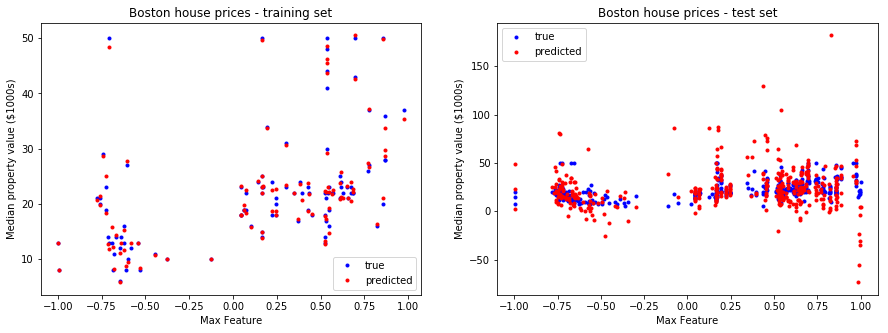

RMSE without regularisation: Train 1.069354, Test 20.134248

### With Regularisation


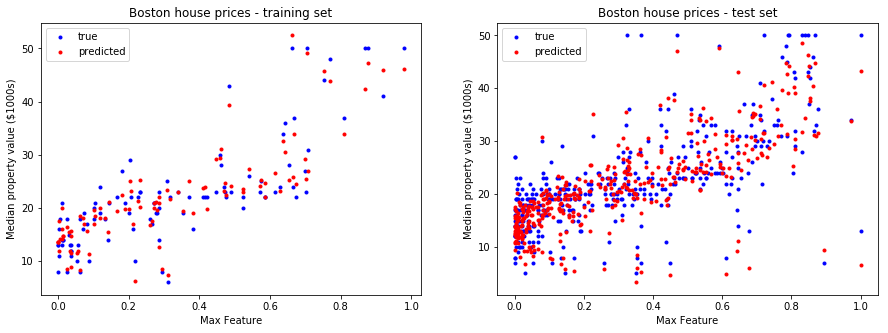

RMSE with basis functions and with regularisation: Train 2.420870, Test 3.605237



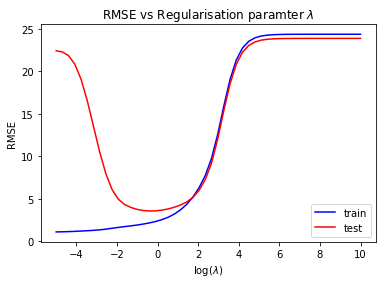

In [11]:
# Solution

# Without Regularisation
print("### Without Regularisation")

Phi_train = np.array([phi_quadratic(X_train[i]) for i in range(X_train.shape[0])])
Phi_test = np.array([phi_quadratic(X_test[i]) for i in range(X_test.shape[0])])

w_unreg = w_ml_unregularised(Phi_train, t_train)
max_feature = np.argmax(np.abs(w_unreg))
t_train_pred = np.dot(Phi_train, w_unreg)
t_test_pred = np.dot(Phi_test, w_unreg)
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
ax.plot(Phi_train[:,max_feature], t_train, 'b.', label='true')
ax.plot(Phi_train[:,max_feature], t_train_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - training set')
ax.set_xlabel("Max Feature")
ax.set_ylabel('Median property value ($1000s)')
x_vals = np.linspace(-1,1)
ax.legend()

ax = fig.add_subplot(122)
ax.plot(Phi_test[:,max_feature], t_test, 'b.', label='true')
ax.plot(Phi_test[:,max_feature], t_test_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - test set')
ax.set_xlabel("Max Feature")
ax.set_ylabel('Median property value ($1000s)')
ax.legend()
plt.show()

train_rmse, test_rmse = rmse(Phi_train, t_train, Phi_test, t_test, w_unreg)
print("RMSE without regularisation: Train {:.6f}, Test {:.6f}".format(train_rmse, test_rmse))
print()

# With Regularisation
print("### With Regularisation")

w_reg = w_ml_regularised(Phi_train, t_train, 1.1)
max_feature = np.argmax(np.abs(w_reg))
t_train_pred = np.dot(Phi_train, w_reg)
t_test_pred = np.dot(Phi_test, w_reg)
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
ax.plot(Phi_train[:,max_feature], t_train, 'b.', label='true')
ax.plot(Phi_train[:,max_feature], t_train_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - training set')
ax.set_xlabel("Max Feature")
ax.set_ylabel('Median property value ($1000s)')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(Phi_test[:,max_feature], t_test, 'b.', label='true')
ax.plot(Phi_test[:,max_feature], t_test_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - test set')
ax.set_xlabel("Max Feature")
ax.set_ylabel('Median property value ($1000s)')
ax.legend()
plt.show()

train_rmse, test_rmse = rmse(Phi_train, t_train, Phi_test, t_test, w_reg)
print("RMSE with basis functions and with regularisation: Train {:.6f}, Test {:.6f}".format(train_rmse, test_rmse))
print()

# RMSE vs Regularisation curve

log_lambdas = np.linspace(-5, 10)
# Each row is a value of lambda
# Columns are respectively ['rmse_train_linear', 'rmse_test_linear']
results = np.zeros((len(log_lambdas), 2))

for ix, l in enumerate(log_lambdas):
    rmse_train, rmse_test = rmse(Phi_train, t_train, Phi_test, t_test, 
                                 w_ml_regularised(Phi_train, t_train, pow(10,float(l))))
    results[ix, 0] = rmse_train
    results[ix, 1] = rmse_test

plt.title('RMSE vs Regularisation paramter $\lambda$')
plt.plot(log_lambdas, results[:,0], 'b-', label='train') # training data
plt.plot(log_lambdas, results[:,1], 'r-', label='test') # test data
plt.xlabel('log($\lambda$)')
plt.ylabel('RMSE')
plt.legend()
plt.show()